The goal of this notebook is to generate data that highlight the value of correlated uncertainty estimates to sequential learning. The Friedman-Grosse function is used to generate 128 output values, `y`, given inputs `x` uniformly generated on [0, 1]^12. The data are then split into two equally-sized chunks to generate a second output, `z`. These two chunks are identified by a "phase" column. For the first chunk, labeled "A" phase, `z` has a strong positive correlation with `y`. For the second chunk, labeled "B" phase, `z` is anti-correlated with `y`. The goal of sequential learning will be to find a point that simultaneously has a large value of both `y` and `z`. In theory, the model will be able to recognize the anti-correlation for points in the B phase, and these points will not be considered good candidates for meeting both objectives.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import math

In [3]:
def FriedmanGrosse(X):
    """The Friedman-Grosse function. Dimensions past 5 are ignored."""
    if len(X.shape) == 1:
        X = np.reshape(X, (1, -1))
    return 10 * np.sin(np.pi * X[:,0] * X[:,1]) + \
        20 * (X[:,2] - 0.5)**2 + \
        10 * X[:,3] + \
        5 * X[:,4]

In [4]:
def generateLinearlyCorrelatedData(x, rho, rng = np.random.default_rng()):
    """Generate data that are linearly correlated with input data, x.
    rho is the desired correlation coefficient.
    rng is a random number generator, for reproducibility.
    """
    assert len(x.shape) == 1, "X must be 1-dimensional"
    y = rng.normal(size = x.size, )
    X = x.reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)
    residuals = y - y_pred
    return rho * np.std(residuals) * x + math.sqrt(1 - rho ** 2) * np.std(x) * residuals

In [5]:
num_cols = 12
num_points = 128

In [6]:
# Generate inputs X, output Y from Friedman-Grosse, and output Z as sqrt(30^2 - y^2)
seed = 6531901145
rng = np.random.default_rng(seed)
X = rng.uniform(low=0.0, high=1.0, size=(num_points, num_cols))
num_A = int(num_points / 2)
# Split into two chunks of data.
X_A = X[:num_A, :]
X_B = X[num_A:, :]
Y_A = FriedmanGrosse(X_A)
Y_B = FriedmanGrosse(X_B)
Z_A = generateLinearlyCorrelatedData(Y_A, 0.98, rng)
Z_B = np.sqrt(30**2 - Y_B**2)

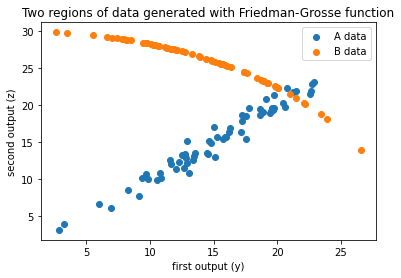

In [29]:
# Plot the data to ensure it has the desired properties
plt.scatter(Y_A, Z_A, label="A data")
plt.scatter(Y_B, Z_B, label="B data")
plt.xlabel("first output (y)")
plt.ylabel("second output (z)")
plt.title("Two regions of data generated with Friedman-Grosse function")
plt.legend()
plt.show()

In [10]:
def make_df(X, Y, Z, phase):
    """Combine X, Y, and Z into a single dataframe."""
    num_points, num_x_cols = X.shape
    assert len(Y) == num_points
    assert len(Z) == num_points
    df_X = pd.DataFrame(data=X, columns=[f"x_{i}" for i in range(num_x_cols)])
    df_other = pd.DataFrame(data={"phase": [phase]*num_points, "y": Y, "z": Z})
    return pd.concat([df_X, df_other], axis=1)

In [11]:
df_A = make_df(X_A, Y_A, Z_A, phase="A")

In [12]:
df_B = make_df(X_B, Y_B, Z_B, phase="B")

In [13]:
df = pd.concat([df_A, df_B], axis=0, ignore_index=True)

In [14]:
df[df["y"] > 22]

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,phase,y,z
21,0.929358,0.653710,0.797578,0.780395,0.730314,0.205159,0.495299,0.383110,0.851800,0.147143,0.343926,0.203845,A,22.661374,21.948502
29,0.886872,0.539663,0.603401,0.838245,0.790461,0.986462,0.954338,0.198913,0.805813,0.954274,0.105736,0.197874,A,22.526030,21.564773
31,0.715608,0.952157,0.839638,0.856736,0.691391,0.458034,0.724146,0.559770,0.540253,0.565460,0.376978,0.419407,A,22.751512,22.854839
61,0.876506,0.692159,0.876006,0.798372,0.529613,0.457647,0.577009,0.639616,0.898312,0.663450,0.707975,0.069513,A,22.903000,23.086941
65,0.649831,0.358901,0.986803,0.889413,0.615011,0.479688,0.638708,0.022706,0.084101,0.655546,0.300311,0.445240,B,23.397491,18.776512
85,0.717748,0.938932,0.021664,0.875379,0.931795,0.892580,0.648662,0.078989,0.371356,0.850696,0.112546,0.833351,B,26.532997,14.000002
108,0.640371,0.624592,0.032030,0.361062,0.933310,0.137962,0.173491,0.392234,0.944317,0.099711,0.505507,0.589238,B,22.167366,20.214051
111,0.694248,0.653660,0.869042,0.637604,0.612329,0.054063,0.346759,0.327805,0.038413,0.849023,0.467037,0.880190,B,22.056380,20.335095
126,0.396540,0.799699,0.174039,0.874060,0.932801,0.051566,0.708045,0.322171,0.538629,0.166961,0.823541,0.319087,B,23.923943,18.100966


Inspecting points for which y > 22 (above), we see that the only ones that there are only two points that also have z > 22, and they are both in the A phase. These points will be the targets.

In [174]:
# Write the data to CSV
df.to_csv("../src/main/resources/friedman_grosse_data.csv", index=False)

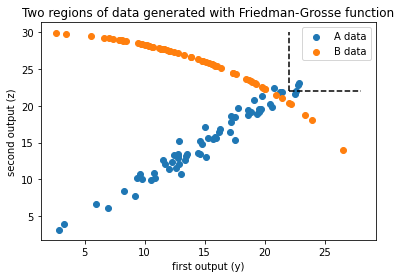

In [8]:
# Re-plot the data, showing the objective region
plt.scatter(Y_A, Z_A, label="A data")
plt.scatter(Y_B, Z_B, label="B data")
plt.hlines(22.0, xmin=22.0, xmax=28.0, linestyles='dashed', colors='k')
plt.vlines(22.0, ymin=22.0, ymax=30.0, linestyles='dashed', colors='k')
plt.xlabel("first output (y)")
plt.ylabel("second output (z)")
plt.title("Two regions of data generated with Friedman-Grosse function")
plt.legend()
plt.show()